In [12]:
#% matplotlib inline
#config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from corner import corner

ModuleNotFoundError: No module named 'corner'

# A Practical Guide to MCMC:
## Part 1: MCMC basics

Markov Chain Monte-Carlo (MCMC) is an art, pure and simple. Throughout my career I have learned several tricks and techniques from varous "artists" of MCMC. In this guide I hope to impart some of that knowledge to newcomers to MCMC while at the same time learning/teaching about proper and pythonic code design. I also hope that this will truly be a practical (i.e. little theoretical statistics knowledge needed) guide to MCMC. By that, I mean that we will treat MCMC as a *tool* not an area of statistical theory to study. To that end we will forego most of the theoretical underpinnings of MCMCs and skip straight to implementation and optimization.

## Overview

In this post you will:

1. Get a brief introduction to MCMC techniques
2. Understand and visualize the Metropolis-Hastings algorithm
3. Implement a Metropolis-Hastings MCMC sampler from scratch
4. Learn about basic MCMC diagnostics
5. Run your MCMC and push its limits on various examples

## Introduction

MCMCs are used to map out and sample probability distribution or probability density functions. The problem of performing probabalistic inference and fitting models to data are ubiquitous in many areas of science, statistics, economics, and business. In short, if you have a probabalistic model with unknown parameters, you will need MCMC (or similar techniques) to obtain probability distributions of those unknown parameters.

Now, there is a *huge* ecosystem of MCMC variants: Metropolis-Hastings sampling, Gibbs Sampling, ensemble sampling, parallel tempering, adaptive MCMC, Hamiltonian Monte-Carlo, Reversible Jump MCMC, etc, but don't panic yet; we will start with a basic Metropolis-Hastings sampler and gradually build (in other posts) to more sophisticated techniques. All of the techniques listed above can be quite useful in certain situations (and sometimes extremely tricky to implement: I'm looking at you Reversible Jump!) but I have found that simple Metropolis-Hastings with a bit of adaptation can handle a large array of high dimensional complex problems.

In this first post we will build a simple Metropolis Hastings sampler. Before we get to the specifics of this algorithm we need to lay down a few ground rules for MCMCs:

1. MCMCs stochastically explore the parameter space in such a way that the histogram of their samples produces the target distribution.
2. Markovian: Evolution of the chain (i.e., collections of samples from one iteration to the other) only depends on the current position and some transition probability distribution (i.e., how we move from one point in parameter space to another). This means that the chain has no memory and past samples cannot be used to determine new positions in parameter space.
3. The chain will converge to the target distribution if the transition probability is:
    * *irreducible*: From any point in parameter space, we must be able to reach any other point in the space in a finite number of steps.
    * *positive recurrent*: For any point in parameter space, the expected number of steps for the chain to return to that point is finite. This means that the chain must be able to re-visit previously explored areas of parameter space. 
    * *aperiodic*: The number of steps to return to a given point must not be a multiple of some value $k$. This means that the chain cannot get caught in cycles.
    
Fear not, this is the most technical thing that we will cover and all MCMC methods will have these rules built in!

## Metropolis Hastings MCMC

Suppose we have a target posterior distribution $\pi(x)$, where $x$ here can be any collection of parameters (not a single parameter). In order to move around this parameter space we must formulate some proposal distribution $q(x_{i+1}|x_i)$, that specifies the probability of moving to a point in parameter space, $x_{i+1}$ given that we are currently at $x_i$. The Metropolis Hastings alogorithm accepts a "jump" to $x_{i+1}$ with the following probability

$$
\kappa(x_{i+1}|x_i) = \mathrm{min}\left(1, \frac{\pi(x_{i+1})q(x_i|x_{i+1})}{\pi(x_{i})q(x_{i+1}|x_{i})}\right) = \mathrm{min}(1, H),
$$
where the fraction above is called the Hastings ratio, $H$. What the above expression means is that the probability of transitioning from point $x_{i+1}$ given the current position $x_i$ is a function of the ratio of the value of the posterior at the new point to the old point (i.e., $\pi(x_{i+1})/\pi(x_i)$) and the ratio of the transition probabilities at the new point to the old point (i.e. $q(x_i|x_{i+1})/q(x_{i+1}|x_i)$). Firstly, it is clear that if this ratio is $>$ 1 then the jump will be accepted (i.e. the chain advances to $x_{i+1}$). Secondly, the ratio of the target posteriors ensures that the chain will gradually move to high probability regions. Lastly, the ratio of the transition probabilities ensures that the chain is not influenced by "favored" locations in the proposal distribution function. If this last point is confusing, never worry, we will give an example of this later. For now, rejoice in the fact that many proposal distributions are symmetric (i.e., $q(x_{i+1}|x_i) = q(x_i|x_{i+1})$).

The metropolis hastings algorithm is then:

1. Initialize parameters $x_0$.
2. for $i=1$ to $i=N$:
    * Generate proposed parameters: $x_* \sim q(x_*|x_i)$
    * Sample from uniform distribution: $u\sim U(0, 1)$
    * Compute Hastings ratio: $H=\frac{\pi(x_{*})q(x_i|x_{*})}{\pi(x_{i})q(x_{*}|x_{i})}$
    * if $u < \mathrm{min}(1,H)$ then $x_{i+1}=x_*$
    * else $x_{i+1} = x_i$
    
For each step in this loop, we draw a proposed parameters $x_*$. We then compute the Hastings ratio using this proposed point. By drawing the number $u\sim U(0,1)$ we allow for a "jump" to $x_*$ with probability $\mathrm{min}(1, H)$. So if $u < \mathrm{min}(1,H)$ thent he jump is accepted then we advance the chain $x_{i+1}=x_*$, if it is not then we stay at the current position $x_i$. If the proposal distribution $q$ obeys the three rules above (irreducible, positive recurrent, and aperiodic) then this algorithm is gaurenteed to work. However, choosing smart proposal distributions is what makes MCMC an art!

Before we get into that, lets write some code for a very simple but illustrative example. By the way, if you are new to this then write this code yourself, don't just read it. Writing your own simple MCMC code is the best way to learn and understand.

## Simple Metropolis Hastings sampler

The best way to learn is to do. So lets make a simple metropolis hastings sampler. The code below implements the MH-sampler through a function `mh_sampler`. This function is simple, but generic enough to work with different kinds of posterior distributions and different kinds of jump proposals

In [4]:
def mh_sampler(x0, lnprob_fn, prop_fn, prop_fn_kwargs={}, iterations=100000):
    """Simple metropolis hastings sampler.
    
    :param x0: Initial array of parameters.
    :param lnprob_fn: Function to compute log-posterior.
    :param prop_fn: Function to perform jumps.
    :param prop_fn_kwargs: Keyword arguments for proposal function
    :param iterations: Number of iterations to run sampler. Default=100000
    
    :returns: 
        (chain, acceptance, lnprob) tuple of parameter chain , acceptance rate 
        and log-posterior chain.
    """
    
    # number of dimensions
    ndim = len(x0)
    
    # initialize chain, acceptance rate and lnprob
    chain = np.zeros((iterations, ndim))
    lnprob = np.zeros(iterations)
    accept_rate = np.zeros(iterations)
    
    # first samples
    chain[0] = x0
    lnprob0 = lnprob_fn(x0)
    lnprob[0] = lnprob0
    
    # start loop
    naccept = 0
    for ii in range(1, iterations):
        
        # propose
        x_star, factor = prop_fn(x0, **prop_fn_kwargs)
        
        # draw random uniform number
        u = np.random.uniform(0, 1)
        
        # compute hastings ratio
        lnprob_star = lnprob_fn(x_star)
        H = np.exp(lnprob_star - lnprob0) * factor
        
        # accept/reject step (update acceptance counter)
        if u < H:
            x0 = x_star
            lnprob0 = lnprob_star
            naccept += 1
        
        # update chain
        chain[ii] = x0
        lnprob[ii] = lnprob0
        accept_rate[ii] = naccept / ii
        
    return chain, accept_rate, lnprob

The function follows the MH-algorithm exactly as written above. It will return the chain samples (i.e. the columns are the parameters and the rows are the sampler iterations), acceptance rate per iteration and log-posterior values per iteration. Generally, this is all the information you need to produce inferences and check convergence and efficiency.

So, now we have a MH-sampler function but we don't yet have a proposal distribution. The simplest proposal distribution is just a draw from the prior distribution; however, this is hugely inefficient, and since this is a *practical* guide lets do something useful. Next to a prior draw, a Gaussian proposal with fixed standard deviation is the simplest proposal. In fact, nearly all other sophisticated proposal distributions are still a Gaussian distribution, albeit without a constant standard deviation / covariance. We will cover these in the next post but for now lets make a simple distribution.

In [5]:
def gaussian_proposal(x, sigma=0.1):
    """ 
    Gaussian proposal distribution.
    
    Draw new parameters from Gaussian distribution with
    mean at current position and standard deviation sigma.
    
    Since the mean is the current position and the standard
    deviation is fixed. This proposal is symmetric so the ratio
    of proposal densities is 1.
    
    :param x: Parameter array
    :param sigma: 
        Standard deviation of Gaussian distribution. Can be scalar
        or vector of length(x)
    
    :returns: (new parameters, ratio of proposal densities)
    """
    
    # Draw x_star
    x_star = x + np.random.randn(len(x)) * sigma
    
    # proposal ratio factor is 1 since jump is symmetric
    qxx = 1
    
    return (x_star, qxx)

This proposal is nearly as simple as it gets, mathematically it is:

$$
q(x_*|x_i) = \textrm{Normal}(x_i, \sigma^2),
$$

that is, a Gaussian centered on the current position $x_i$ with variance given by a standard deviation parameter $\sigma$.

Ok now we have our sampler and our proposal distribution, lets test this out on a very simple 1-D Gaussian likelihood function with an unknown mean and unit variance. We will use a uniform prior on the mean $\mu \sim U(-10, 10)$. Of course, we don't actually need MCMC to sampler this distribution but it works as a good example that is easy to visualize.

In [6]:
def simple_gaussian_lnpost(x):
    """
    1-D Gaussian distribution with mean 0 std 1.
    
    Prior on mean is U(-10, 10)
    
    :param x: Array of parameters
    
    :returns: log-posterior
    
    """
    mu = 0
    std = 1
    
    if x < 10 and x > -10:
        return -0.5 * (x-mu)**2 / std**2
    else:
        return -1e6

### Visualizing the MH-step

Before we run a long chain, lets try to visualize what it going on at each iteration.

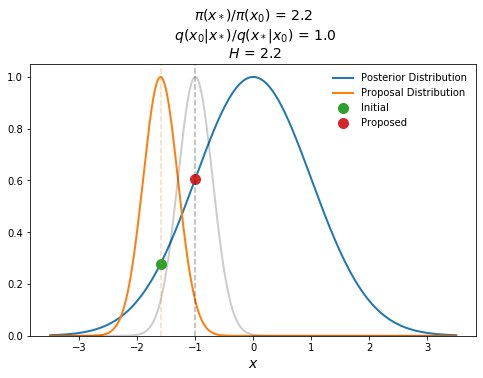

In [7]:
xx = np.linspace(-3.5, 3.5, 1000)
x0 = np.array([-1.6])
xs = np.array([-1.0])
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

ax.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 
        label='Posterior Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=x0, scale=0.3).pdf(xx)/scipy.stats.norm(loc=x0, scale=0.3).pdf(xx).max(), 
        alpha=1.0, label='Proposal Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=xs, scale=0.3).pdf(xx)/scipy.stats.norm(loc=x0, scale=0.3).pdf(xx).max(), 
        alpha=0.2, color='k', lw=2)
ax.plot(x0, scipy.stats.norm(loc=0, scale=1).pdf(x0)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Initial', markersize=10)
ax.plot(xs, scipy.stats.norm(loc=0, scale=1).pdf(xs)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Proposed', markersize=10)
ax.axvline(xs, ls='--', color='k', alpha=0.3)
ax.axvline(x0, ls='--', color='C1', alpha=0.3)

# posterior ratio
pr = np.exp(simple_gaussian_lnpost(xs) - simple_gaussian_lnpost(x0))

# proposal ratio
qxy = scipy.stats.norm(loc=xs, scale=0.3).pdf(x0)
qyx = scipy.stats.norm(loc=x0, scale=0.3).pdf(xs)
H = pr * qxy/qyx

ax.set_title('$\pi(x_*)/\pi(x_0)$ = {:2.2}\n $q(x_0|x_*)/q(x_*|x_0)$ = {:2.2}\n $H$ = {:2.2}'.format(pr[0], (qxy/qyx)[0], H[0]), 
             fontsize=14)

ax.set_ylim(ymin=0)
plt.legend(loc='best', frameon=False)
ax.set_xlabel(r'$x$', fontsize=14);

The plot above shows a schematic of a succesful jump. The blue shows the 1-D Gaussian posterior distribution, the orange is the Gaussian proposal distribution, $q(x_*|x_0)$, ($\sigma=0.5$), and the green and red points are the initial and proposed parameters, respectively. For illustratin purposes, the gray curve shows $q(x_0|x_*)$ to show the symmetry of the proposal distribution. In this case we see that the proposed point returns a Hastings ratio of 2.2 (i.e. transition probability of 1) and therefore the jump will be accepted.

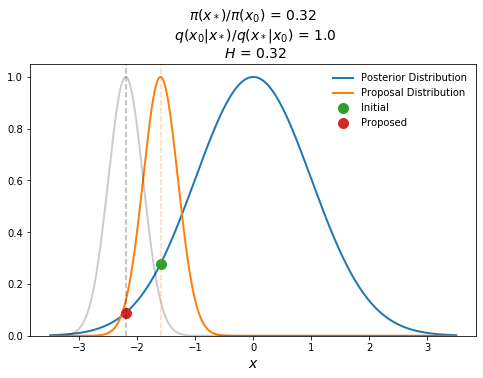

In [8]:
xx = np.linspace(-3.5, 3.5, 1000)
x0 = np.array([-1.6])
xs = np.array([-2.2])
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

ax.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 
        label='Posterior Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=x0, scale=0.3).pdf(xx)/scipy.stats.norm(loc=x0, scale=0.3).pdf(xx).max(), 
        alpha=1.0, label='Proposal Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=xs, scale=0.3).pdf(xx)/scipy.stats.norm(loc=x0, scale=0.3).pdf(xx).max(), 
        alpha=0.2, color='k', lw=2)
ax.plot(x0, scipy.stats.norm(loc=0, scale=1).pdf(x0)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Initial', markersize=10)
ax.plot(xs, scipy.stats.norm(loc=0, scale=1).pdf(xs)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Proposed', markersize=10)
ax.axvline(xs, ls='--', color='k', alpha=0.3)
ax.axvline(x0, ls='--', color='C1', alpha=0.3)

# posterior ratio
pr = np.exp(simple_gaussian_lnpost(xs) - simple_gaussian_lnpost(x0))

# proposal ratio
qxy = scipy.stats.norm(loc=xs, scale=0.3).pdf(x0)
qyx = scipy.stats.norm(loc=x0, scale=0.3).pdf(xs)
H = (pr * qxy/qyx)[0]

ax.set_title('$\pi(x_*)/\pi(x_0)$ = {:2.2}\n $q(x_0|x_*)/q(x_*|x_0)$ = {:2.2}\n $H$ = {:2.2}'.format(pr[0], (qxy/qyx)[0], H), 
             fontsize=14)


ax.set_ylim(ymin=0)
plt.legend(loc='best', frameon=False)
ax.set_xlabel(r'$x$', fontsize=14);

In this plot, we show what happens when a jump is proposed to a lower probability region. The transition probability is equal to the Hasttings ration here (remember transition probability is $\mathrm{min}(1,H)$) which is 0.32, which means that we will move to this new point with 32% probability. This ability to move back down the posterior distribution is what allows MCMC to sample the full probability distribution instead of just finding the global maximum.

As I promised above, lets give a quick demonstration of what happens with a *non-symmetric* proposal distribution. Lets suppose we have the same posterior but now we use a proposal from a fixed Gaussian distribution (i.e. the mean does not change with current position).

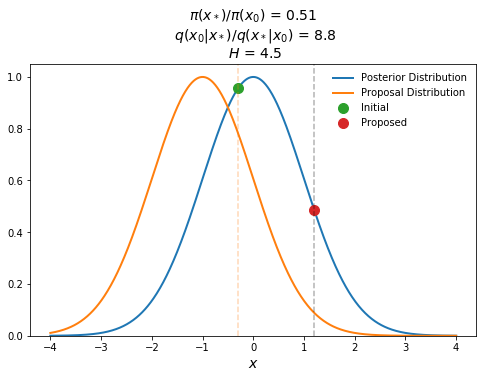

In [9]:
xx = np.linspace(-4., 4, 1000)
x0 = np.array([-0.3])
xs = np.array([1.2])
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

ax.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 
        label='Posterior Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xx)/scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xx).max(), 
        alpha=1.0, label='Proposal Distribution', lw=2)
ax.plot(x0, scipy.stats.norm(loc=0, scale=1).pdf(x0)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Initial', markersize=10)
ax.plot(xs, scipy.stats.norm(loc=0, scale=1).pdf(xs)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Proposed', markersize=10)
ax.axvline(xs, ls='--', color='k', alpha=0.3)
ax.axvline(x0, ls='--', color='C1', alpha=0.3)

# posterior ratio
pr = np.exp(simple_gaussian_lnpost(xs) - simple_gaussian_lnpost(x0))

# proposal ratio
qxy = scipy.stats.norm(loc=-1.0, scale=1.0).pdf(x0)
qyx = scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xs)
H = (pr * qxy/qyx)[0]

ax.set_title('$\pi(x_*)/\pi(x_0)$ = {:2.2}\n $q(x_0|x_*)/q(x_*|x_0)$ = {:3.3}\n $H$ = {:2.2}'.format(pr[0], (qxy/qyx)[0], H), 
             fontsize=14)


ax.set_ylim(ymin=0)
plt.legend(loc='best', frameon=False)
ax.set_xlabel(r'$x$', fontsize=14);

In the above plot we show that the proposal distribution is a fixed Gaussian $q(x_*|x_0)\sim \textrm{Normal(-1, 1)}$. Here we show that even though the proposed point is at a *lower* posterior probability than the initial point, the Hastings ratio is still $>1$ (will accept jump with 100% probability). Qualitatively this makes sense because we need to weight that proposed point higher to take into account for the fact that the proposed point is "hard" to get to even though it still has a relatively high posterior probability value.

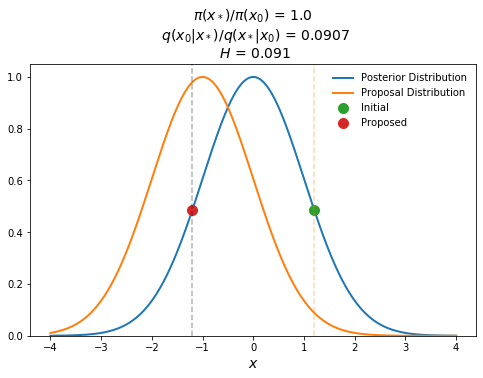

In [10]:
xx = np.linspace(-4., 4, 1000)
x0 = np.array([1.2])
xs = np.array([-1.2])
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

ax.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 
        label='Posterior Distribution', lw=2)
ax.plot(xx, scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xx)/scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xx).max(), 
        alpha=1.0, label='Proposal Distribution', lw=2)
ax.plot(x0, scipy.stats.norm(loc=0, scale=1).pdf(x0)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Initial', markersize=10)
ax.plot(xs, scipy.stats.norm(loc=0, scale=1).pdf(xs)/scipy.stats.norm(loc=0, scale=1).pdf(xx).max(), 'o', 
        label='Proposed', markersize=10)
ax.axvline(xs, ls='--', color='k', alpha=0.3)
ax.axvline(x0, ls='--', color='C1', alpha=0.3)

# posterior ratio
pr = np.exp(simple_gaussian_lnpost(xs) - simple_gaussian_lnpost(x0))

# proposal ratio
qxy = scipy.stats.norm(loc=-1.0, scale=1.0).pdf(x0)
qyx = scipy.stats.norm(loc=-1.0, scale=1.0).pdf(xs)
H = (pr * qxy/qyx)[0]

ax.set_title('$\pi(x_*)/\pi(x_0)$ = {:2.2}\n $q(x_0|x_*)/q(x_*|x_0)$ = {:3.3}\n $H$ = {:2.2}'.format(pr[0], (qxy/qyx)[0], H), 
             fontsize=14)


ax.set_ylim(ymin=0)
plt.legend(loc='best', frameon=False)
ax.set_xlabel(r'$x$', fontsize=14);

In this last example, we show the opposite effect. In this case, even though the posterior probabilies are the same for the current and proposed points, the Hastings ratio is only 0.09 (i.e. 9% chance of accepting jump). Again, with some thought this makes sense. The proposed point must be weighted down because it is near the peak of the proposal distribution (i.e. lots of points will be proposed around this position) and therefore is "easy" to get to even though the posterior probability is no different than at the initial point.

In many cases we do not need to worry about the proposal densities as many proposal distributions are symmetric but you always need to keep it in mind when constructing your own jump proposals as it can leat to biased results if not correctly taken into account. I will show how to easily check for the correct ratios later in this series.

## Diagnosing efficiency and convergence

Now that we understand the Metropolis Hastings step. Lets actually run our sampler on the simple 1-D gaussian likelihood. Since this is only a 1-D problem it is quite easy to determine the optimal jump size but lets explore different values for illustration purposes.

In [11]:
def run_mcmc_plots(sigma):
    x0 = np.random.randn(1)
    chain, ar, lnprob = mh_sampler(x0, simple_gaussian_lnpost, gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma})

    plt.figure(figsize=(15, 8))

    burn = int(0.1 * chain.shape[0])

    plt.subplot(221)
    plt.hist(chain[burn:, 0], 50, normed=True);
    plt.xlabel(r'$x$', fontsize=15)
    xx = np.linspace(-3.5, 3.5, 1000)
    plt.plot(xx, scipy.stats.norm(loc=0, scale=1).pdf(xx), lw=2)

    plt.subplot(222)
    plt.plot(chain[burn:, 0])
    plt.ylabel(r'$x$', fontsize=15)
    plt.axhline(0.0, lw=2, color='C1')

    plt.subplot(223)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)

    plt.subplot(224)
    plt.plot(ar[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)
    
    plt.suptitle(r'$\sigma = {}$'.format(sigma), fontsize=15, y=1.02)
    plt.tight_layout()

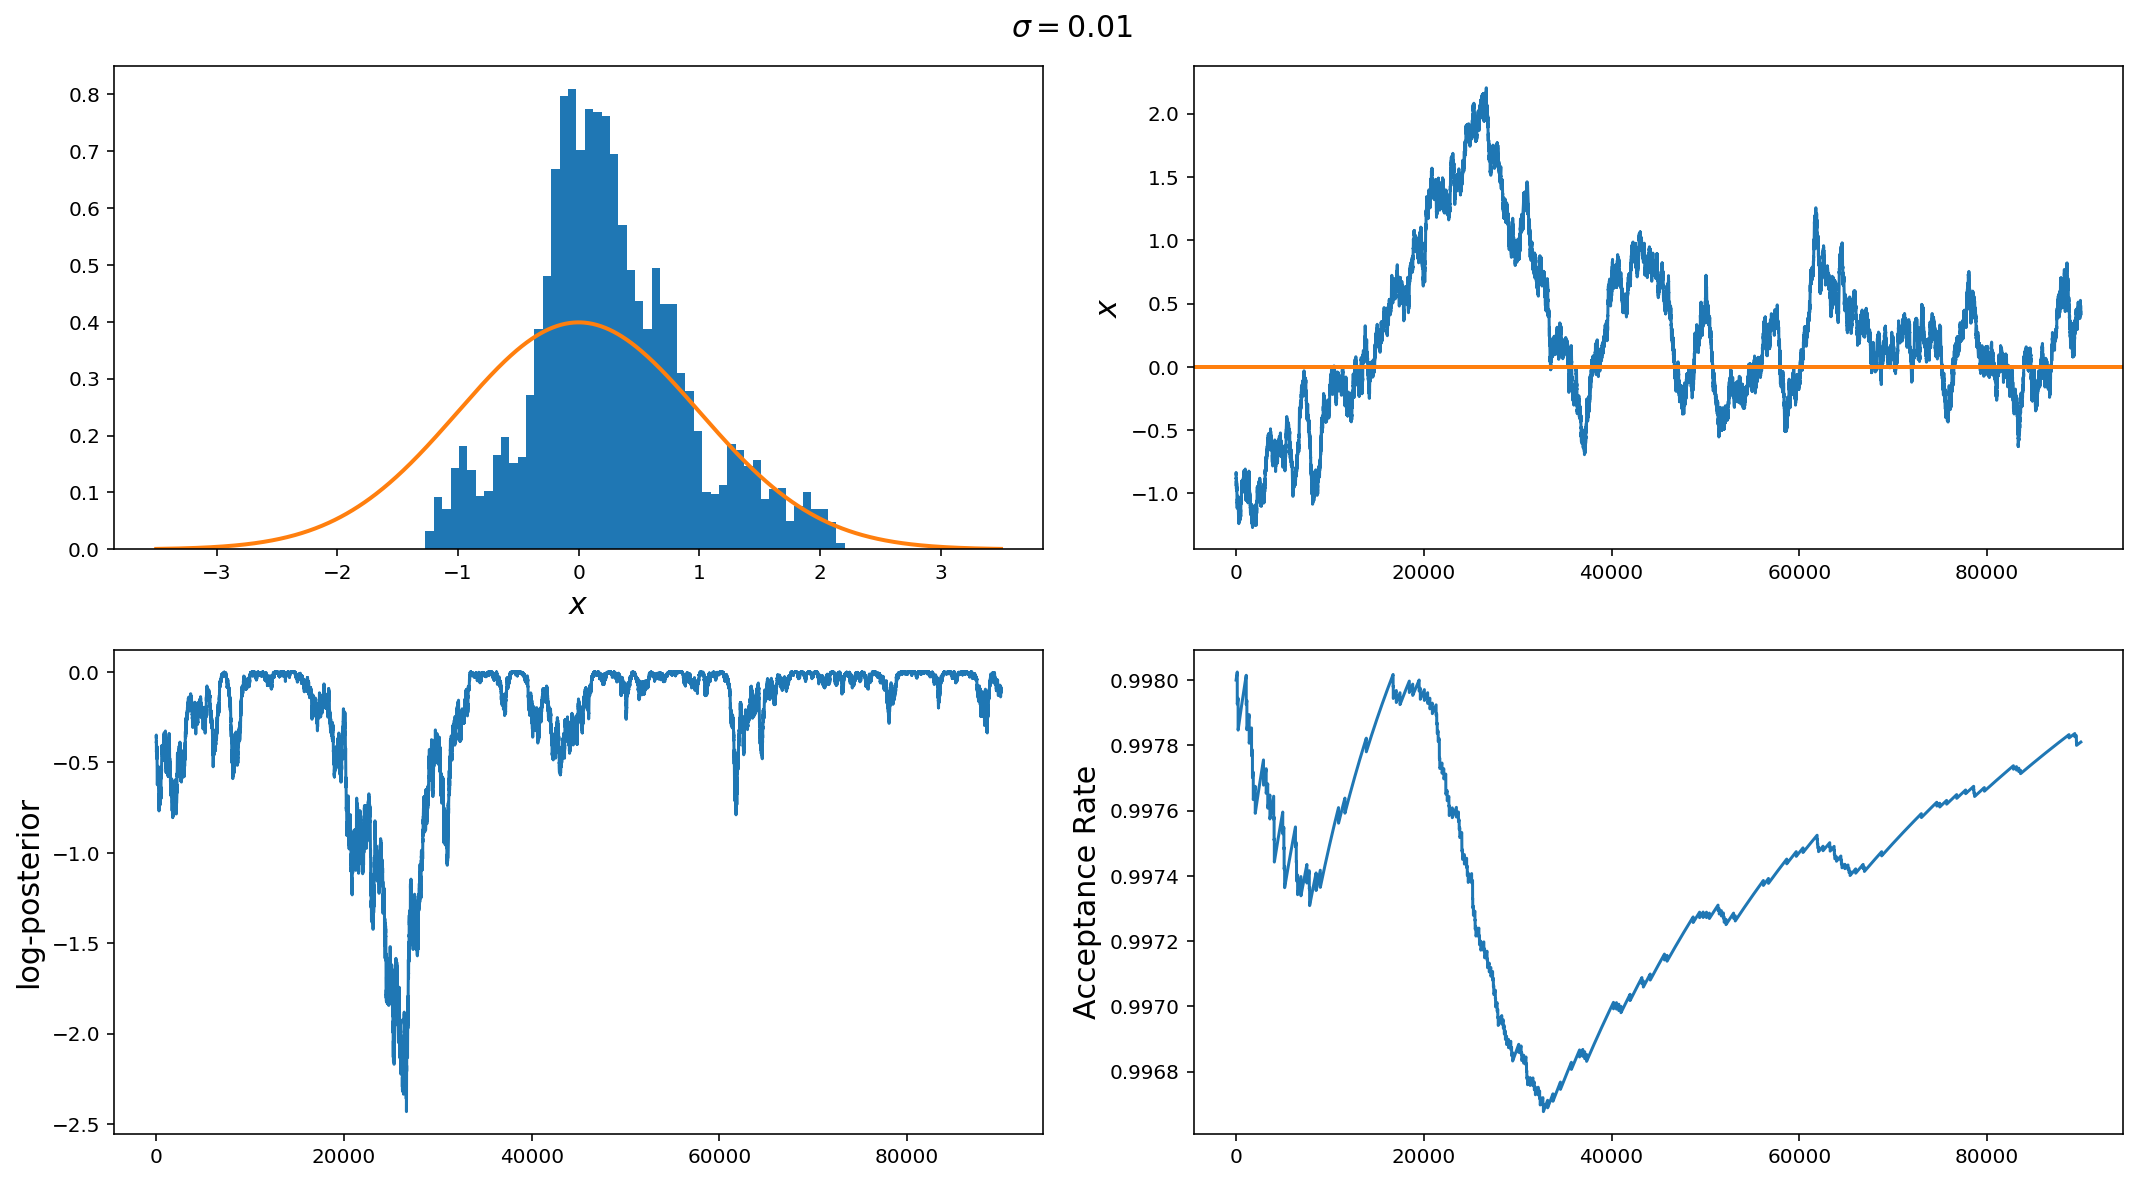

In [12]:
run_mcmc_plots(0.01)

The panels are (from top left to bottom right): Histogram of samples, sample vs iteration (i.e. trace plot), log-posterior vs iteration, and proposal acceptance rate vs iteration. 

In an optimally performing MCMC, the histogram of samples should converge to the posterior distribution, the trace of the chain should sample around the maximum of the posterior such that the samples are close to i.i.d (independent, identical distribution). The log-posterior chain should be smoothly varying around the maximum. Lastly, the acceptance rate depends on the problem but typically for 1-d problems, the acceptance rate should be around 44% (around 23% for more than 5 parameters). There are more sophisticated ways of diagnosing convergence (it gets harder with many parameters) which we will get into in further posts, but plots like this get you a long way to diagnosing problems with your sampler.

In this example we have used a jump standard deviation of 0.01 (remember the standard deviation of the posterior) is 1.0. So, it is clear that the histogram of samples is very poorly reproducing the posterior, the chain trace has large timescale (iteration scale) correlations (i.e. it very slowly varies around the mean). We can also see that around the middle of the run, the chain drifted off from the high probability region (bottom left plot) and it took wuite a large number of samples to get back because of the small jump size. Lastly, we can see that the acceptance rate is 99%. 

Overall, if you see something like this, the first step is to increase the jump proposal size.

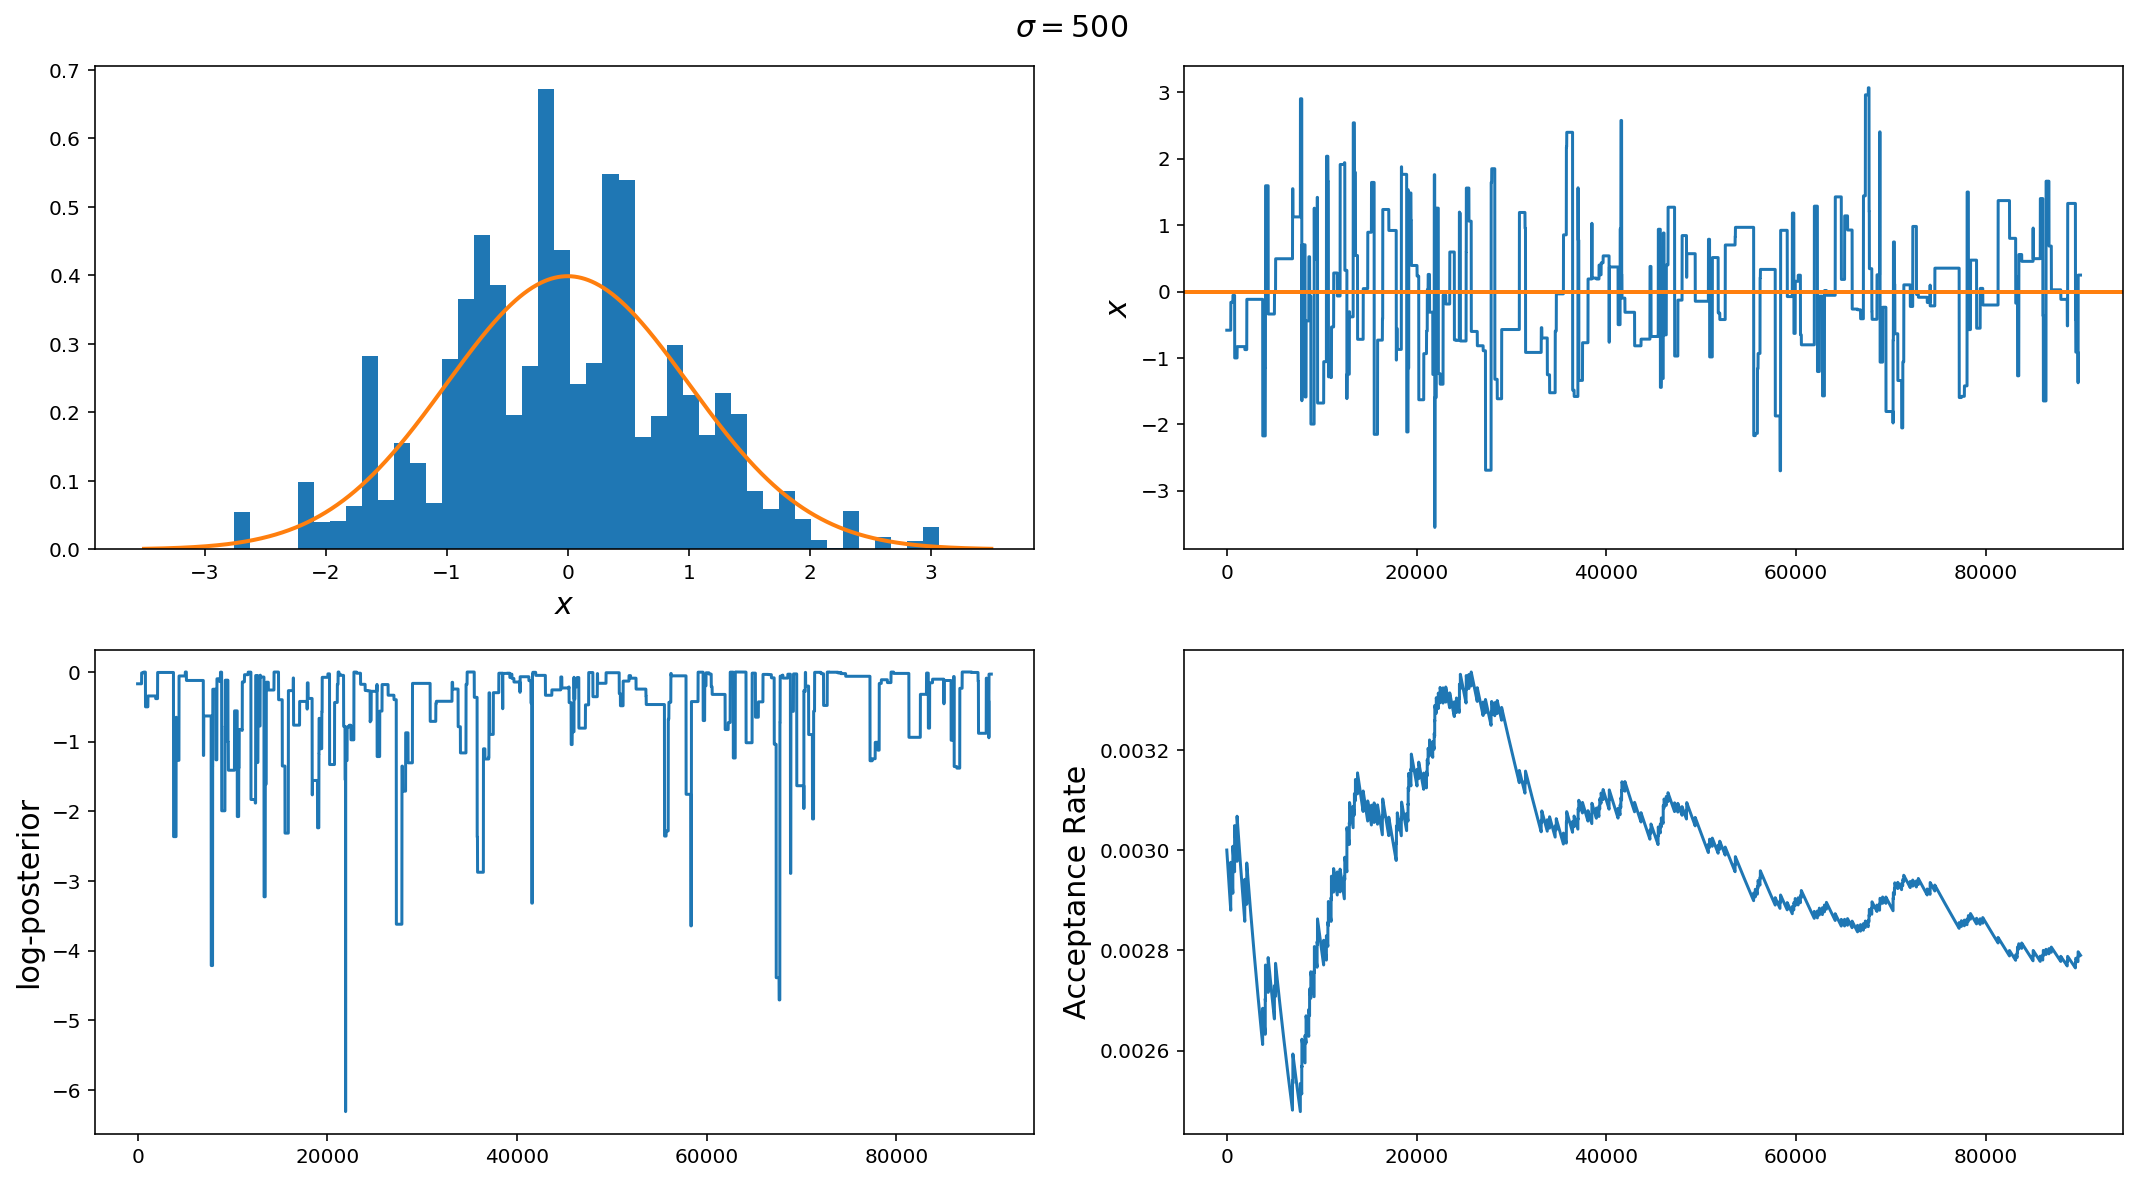

In [13]:
run_mcmc_plots(500)

Ok, so $\sigma=0.01$ was too small, what about $\sigma=500$? Here we see the opposite of the first example. The jump size here is way too big. While we did do a better job at recovering the posterior, we can see from the choppiness of the trace plots and low acceptance rate that this run is very inefficent as it spends a lot of time at fixed locations in parameter space and rarely moves. 

If you see something like this, the first thing to do is to *decrease* the jump proposal size.

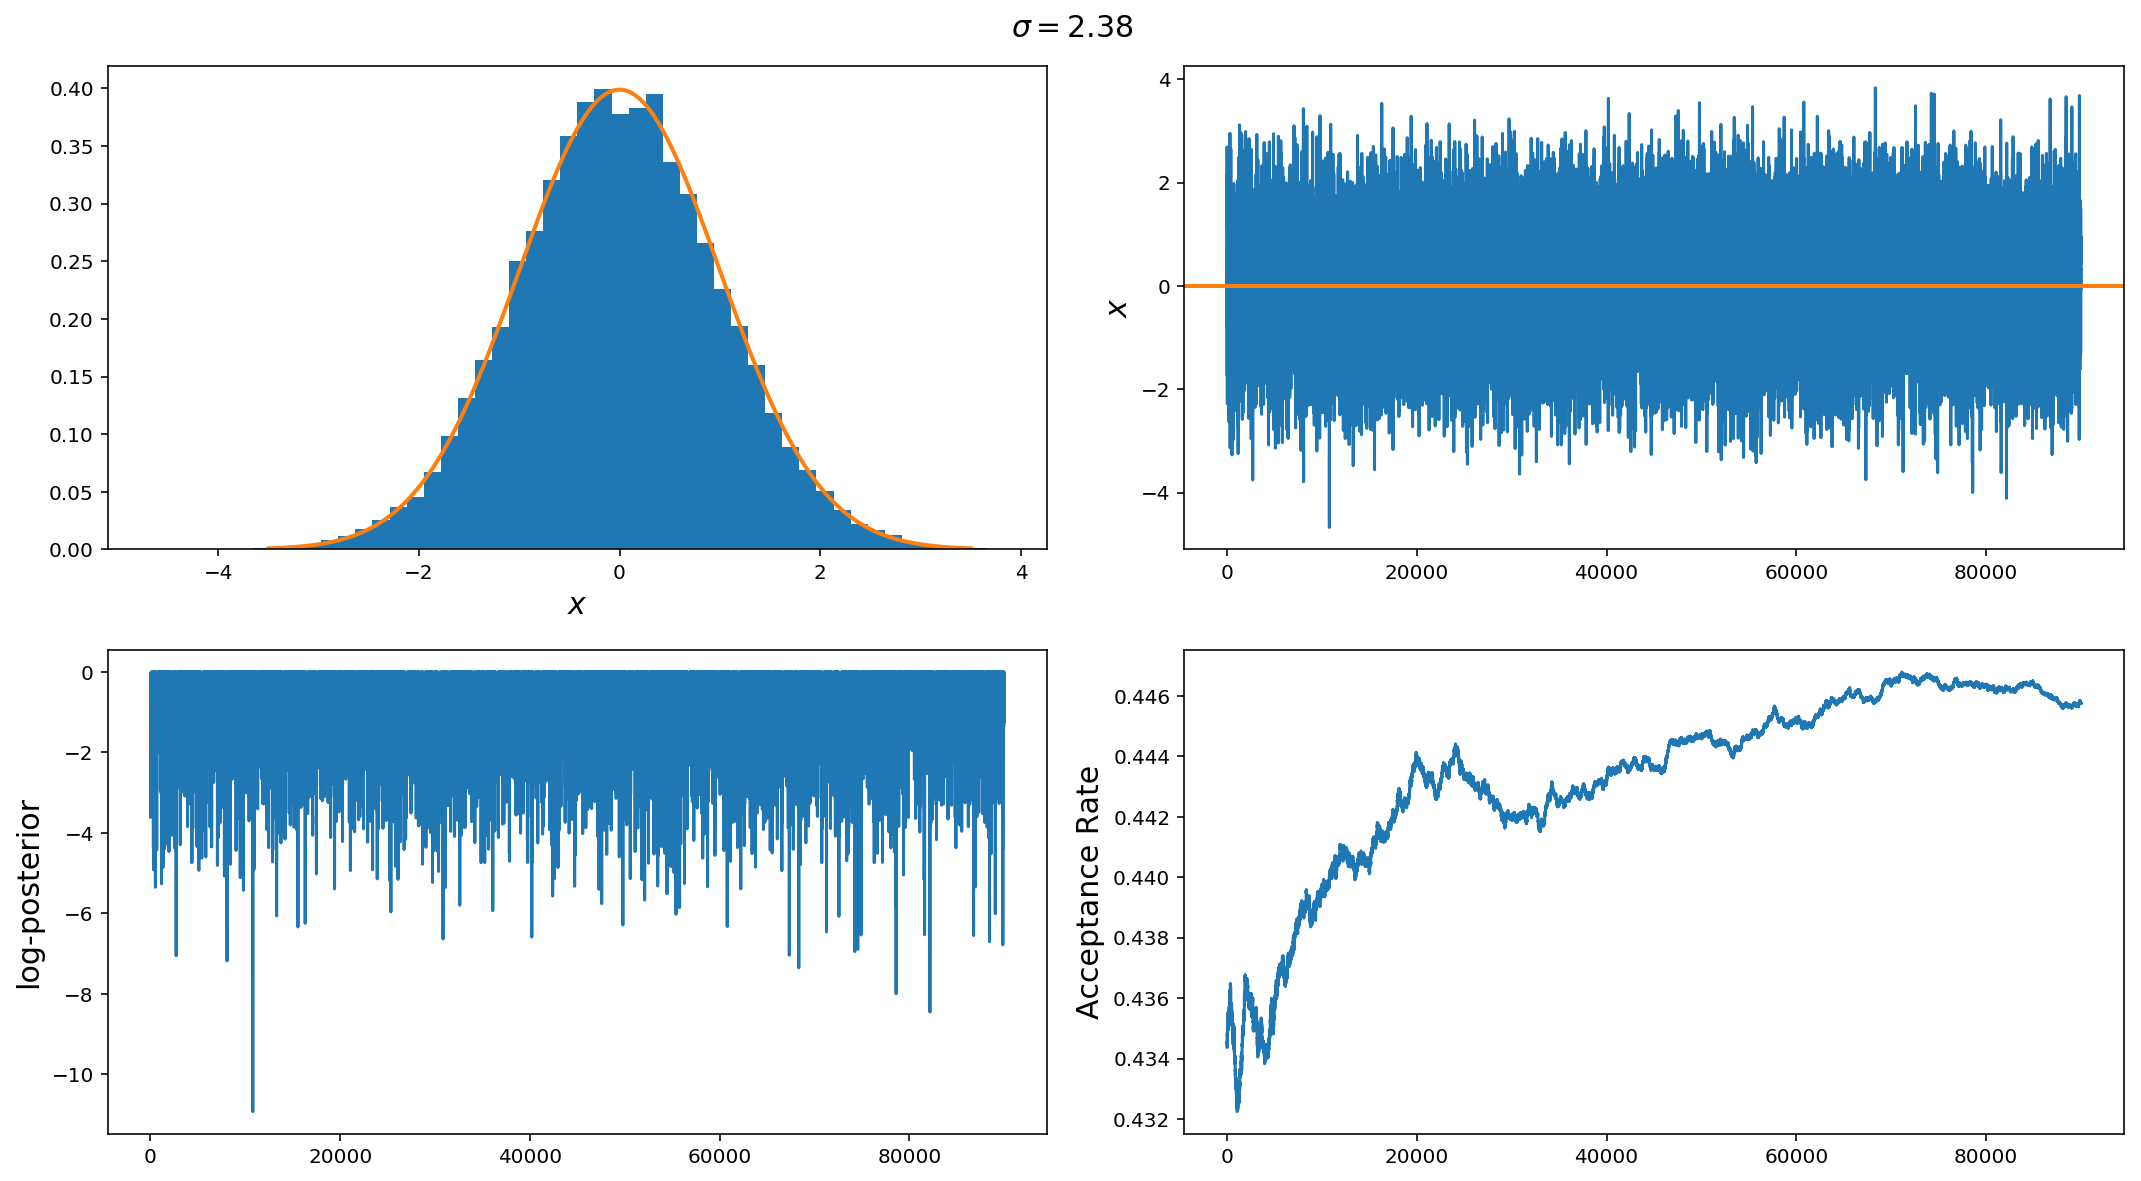

In [14]:
run_mcmc_plots(2.38)

Finally, we have a good jump proposal size. Actually this is the optimal step size for a gaussian distribution $\sigma_{\rm jump} = 2.38 \sigma_{\rm posterior} / n_{\rm dim}$. In this case we can see that the samples are near perfect draws from the posterior distribution, the chain trace is nearly i.i.d and the acceptance rate is 44%

The above illustrates the point but it is so easy that it may be hard to see why MCMCs are so important but difficult to implement efficiently. Before we wrap up for this week, lets look at two more, slightly difficult examples.

## A (slightly) more complicated problem

We have tacked a 1-D Gaussian posterior. Lets now look at a 10-D problem. This posterior distribution has the following properties

$$
\sigma^2 \sim \textrm{LogNormal}(0,1.5)\\
\mu \sim \textrm{Normal}(0, 10)
$$

That is it is a gaussian with variance drawn from a Log-Normal distribution and the means are drawn from a normal distribution with 0 mean and variance 10. This way, we can have multiple scales present in the posterior.

In [15]:
class multi_gaussian_lnpost:
    """
    N-Dimensional Gaussian distribution with 
    
    mu ~ Normal(0, 10)
    var ~ LogNormal(0, 1.5)
    
    Prior on mean is U(-500, 500)
    
    :param ndim: Numver of dimensions to gaussian (default=10)
    :param seed: Random number seed for reproducible results.
    
    """
    
    def __init__(self, ndim=10, seed=12345):
        np.random.seed(seed)
        self.var = 10**(np.random.randn(ndim)*1.5)
        self.mu = scipy.stats.norm(loc=0, scale=10).rvs(ndim)

    def __call__(self, x):
        """
        Call multivariate normal posterior.
        
        :param x: Array of parameters
    
        :returns: log-posterior
        """
        
        if np.all(x < 500) and np.all(x > -500):
            return scipy.stats.multivariate_normal(mean=self.mu, cov=self.var).logpdf(x)
        else:
            return -1e6

In [16]:
def run_mcmc_plots_10d(sigma, iterations=10000):
    x0 = np.random.randn(10)
    chain, ar, lnprob = mh_sampler(x0, multi_gaussian_lnpost(), gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma}, iterations=iterations)

    burn = int(0.1 * chain.shape[0])
    
    lp = multi_gaussian_lnpost()
    mu, std = lp.mu, np.sqrt(lp.var)

    plt.figure(figsize=(15, 6))
    for ii in range(10):
        plt.subplot(4,3,ii+1)
        plt.hist(chain[burn:, ii], 50, normed=True);
        plt.xlabel(r'$x_{}$'.format(ii))
        xx = np.linspace(mu[ii]-3*std[ii], mu[ii]+3*std[ii], 1000)
        plt.plot(xx, scipy.stats.norm(loc=mu[ii], scale=std[ii]).pdf(xx))
    plt.tight_layout()
 
    plt.figure(figsize=(15, 6))
    for ii in range(10):
        plt.subplot(4,3,ii+1)
        plt.plot(chain[burn:, ii]);
        plt.ylabel(r'$x_{}$'.format(ii))
        plt.axhline(mu[ii], color='C1')
    plt.tight_layout()

    plt.figure(figsize=(15, 3))
    
    plt.subplot(121)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)

    plt.subplot(122)
    plt.plot(ar[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)
    

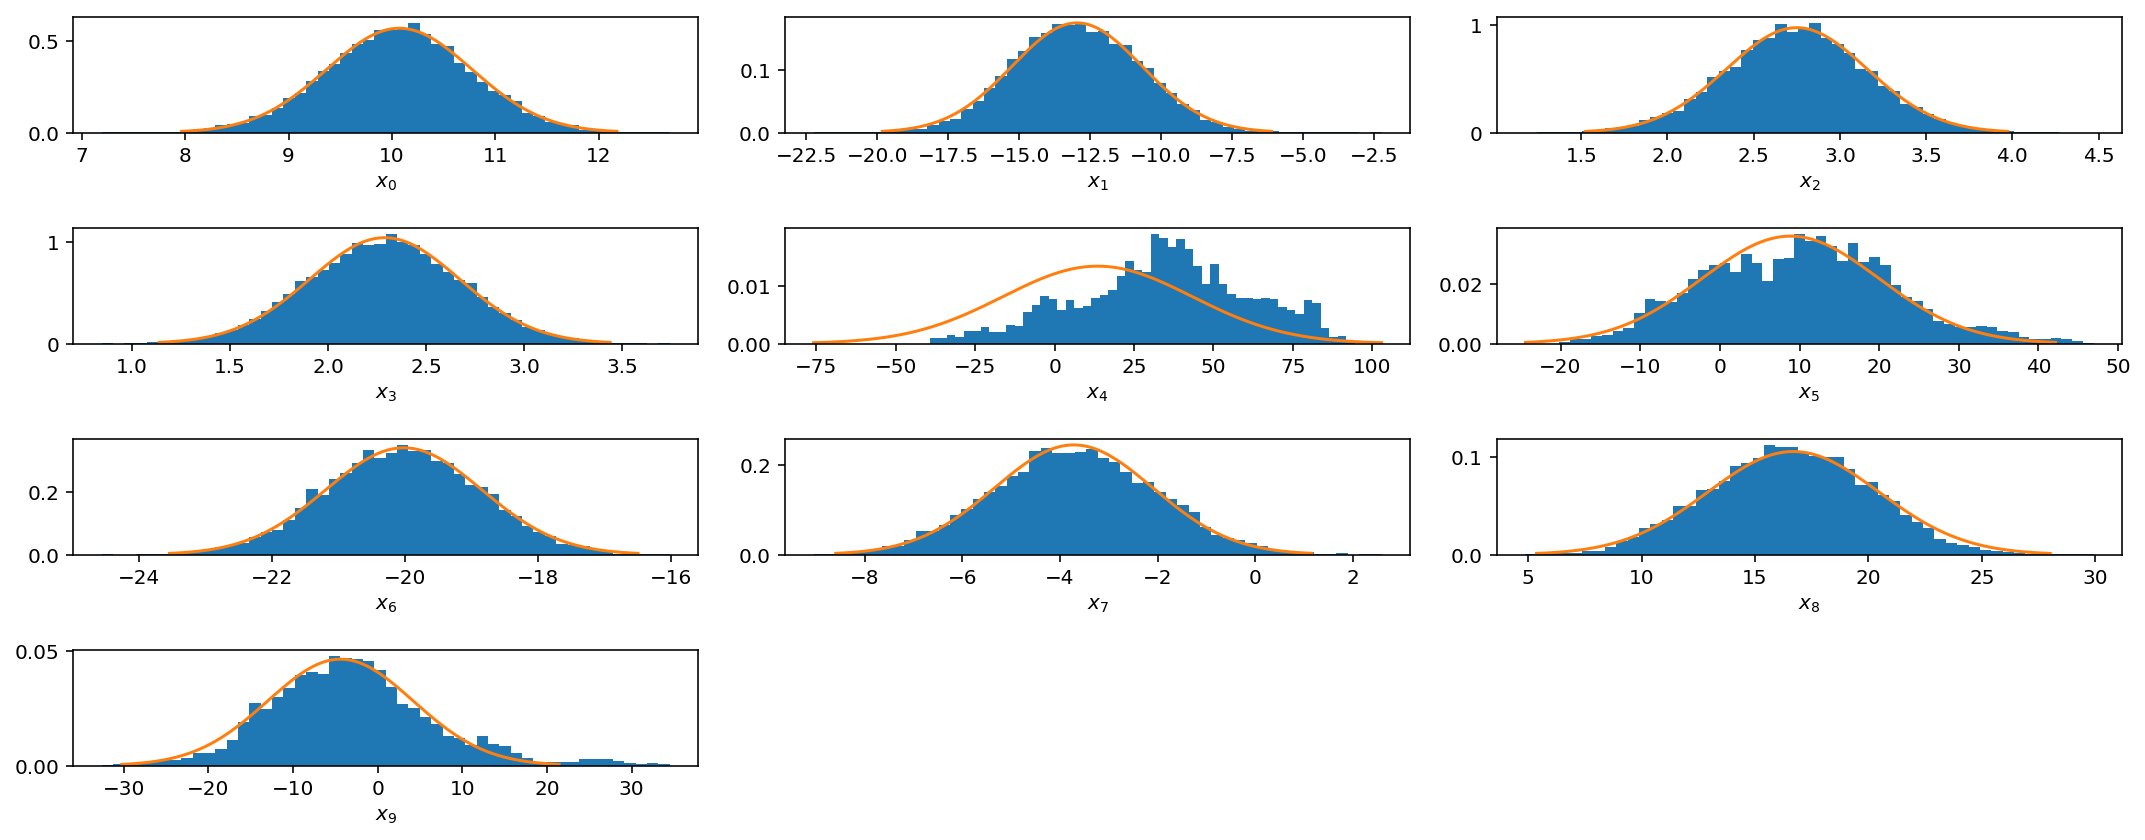

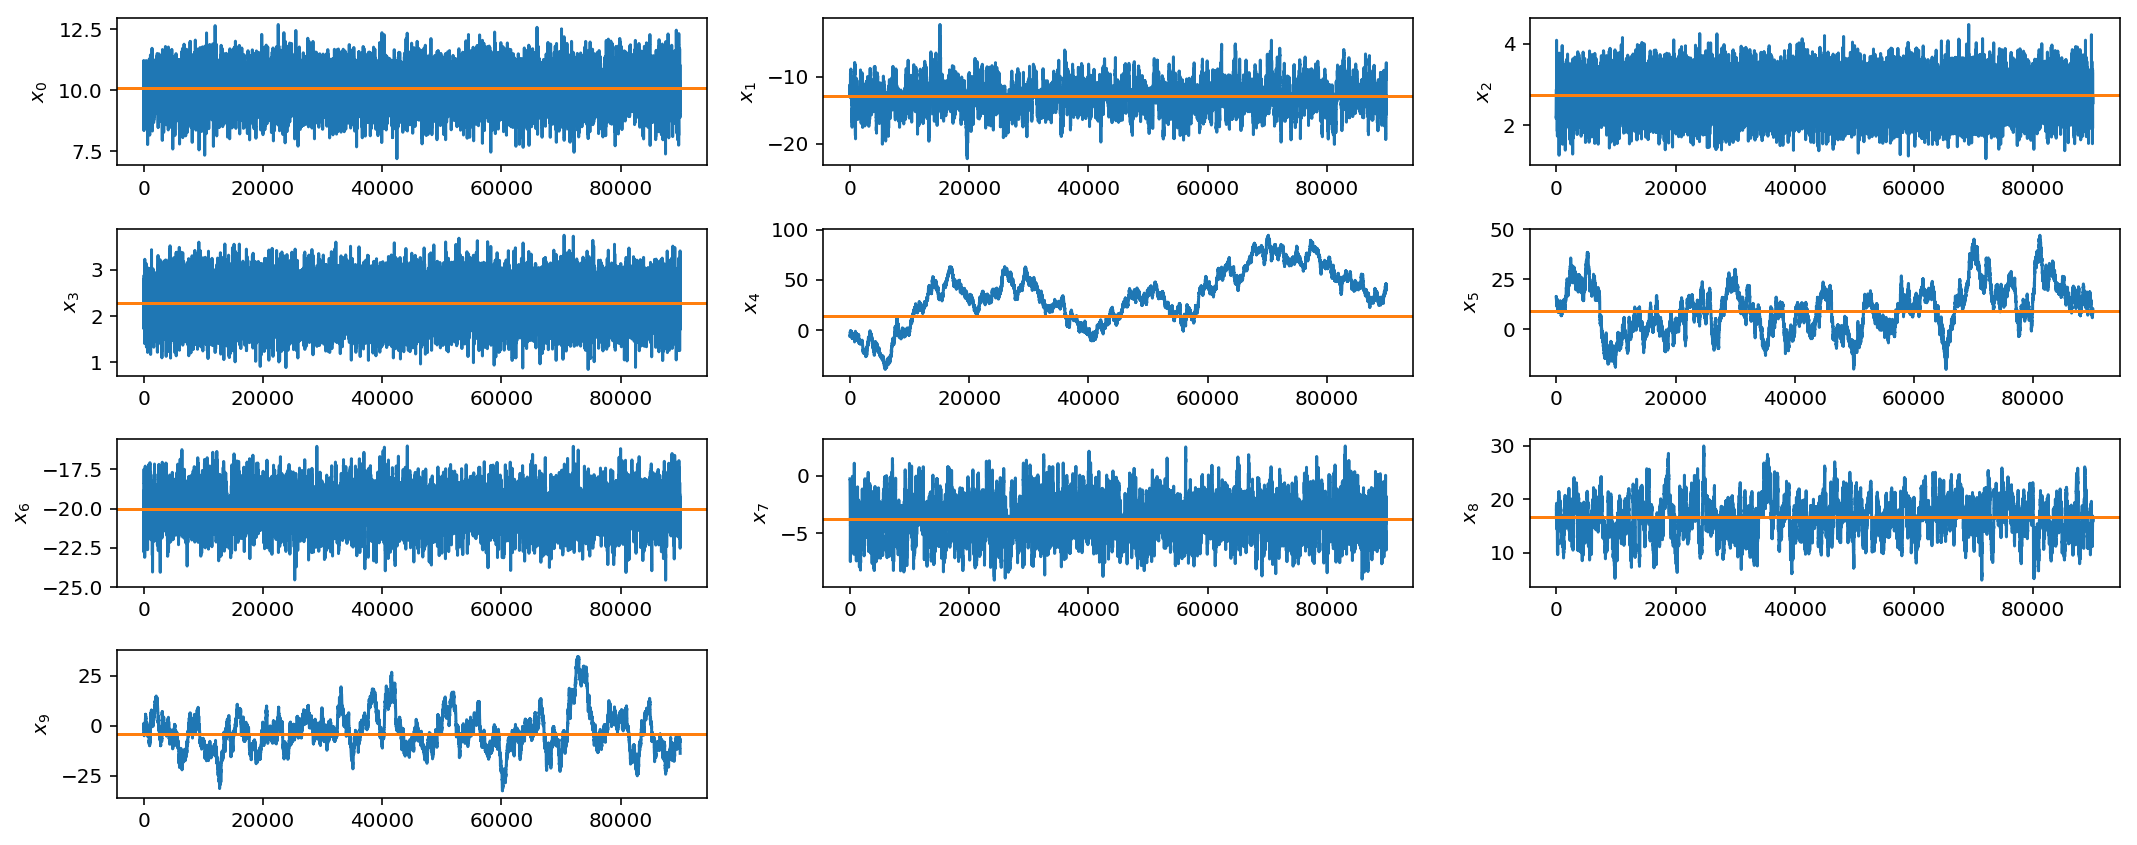

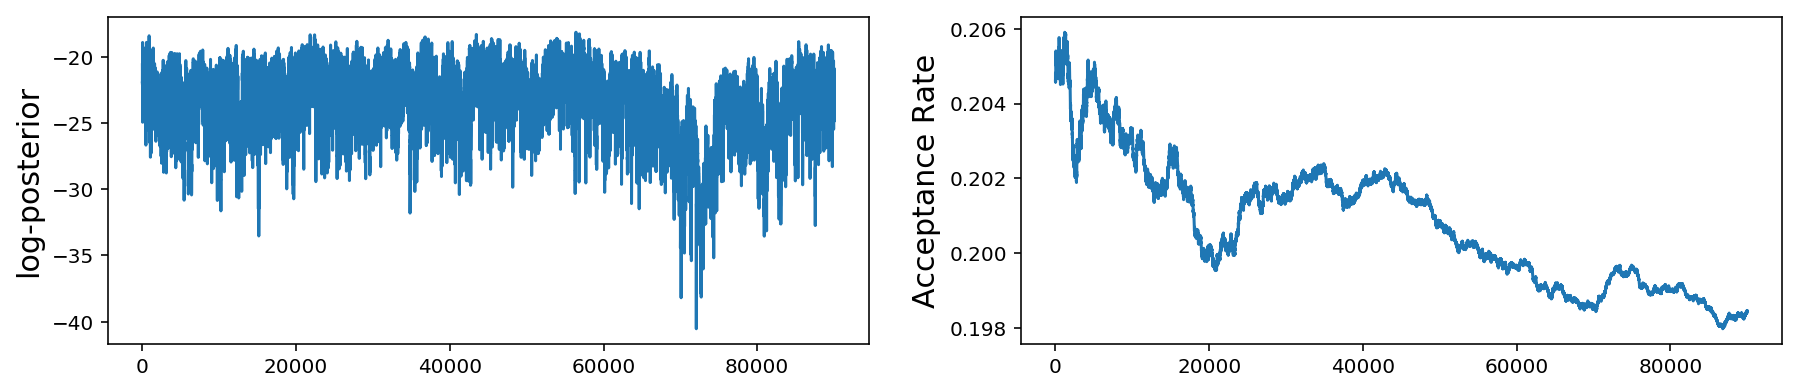

In [17]:
run_mcmc_plots_10d(0.8, iterations=100000)

These plots are the same as those for the 1-D problem but now we show the histogram and trace for all 10 mean parameters. As before, the bottom plot shows the log-posterior vs iteration and the acceptance rate vs iteration.

We see that even if we have multiple scales present, we can still do fairly well with our very simple jump proposal with a single step size. However as we get to larger parameter spaces this begins to pose a problem.

However, if you see these kinds of results, it would be best to try different jump sizes for different parameters. For example, I will increas the jump size for parameters $x_4$, $x_5$, and $x_9$.

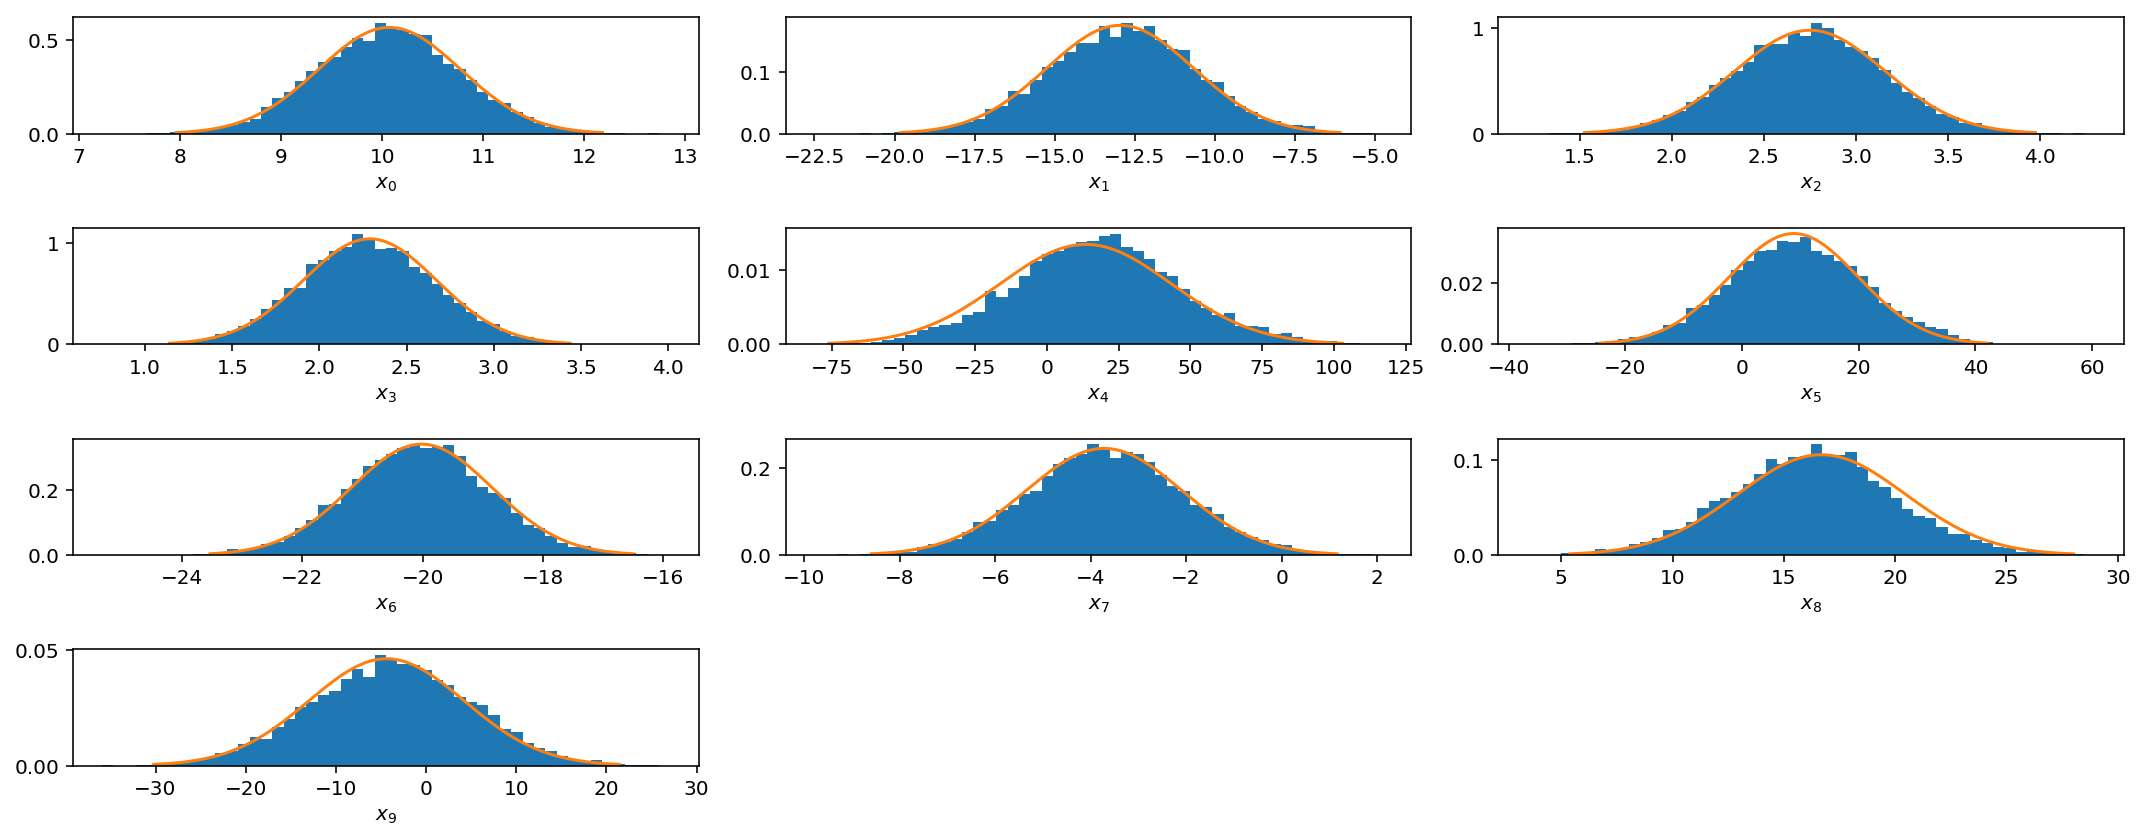

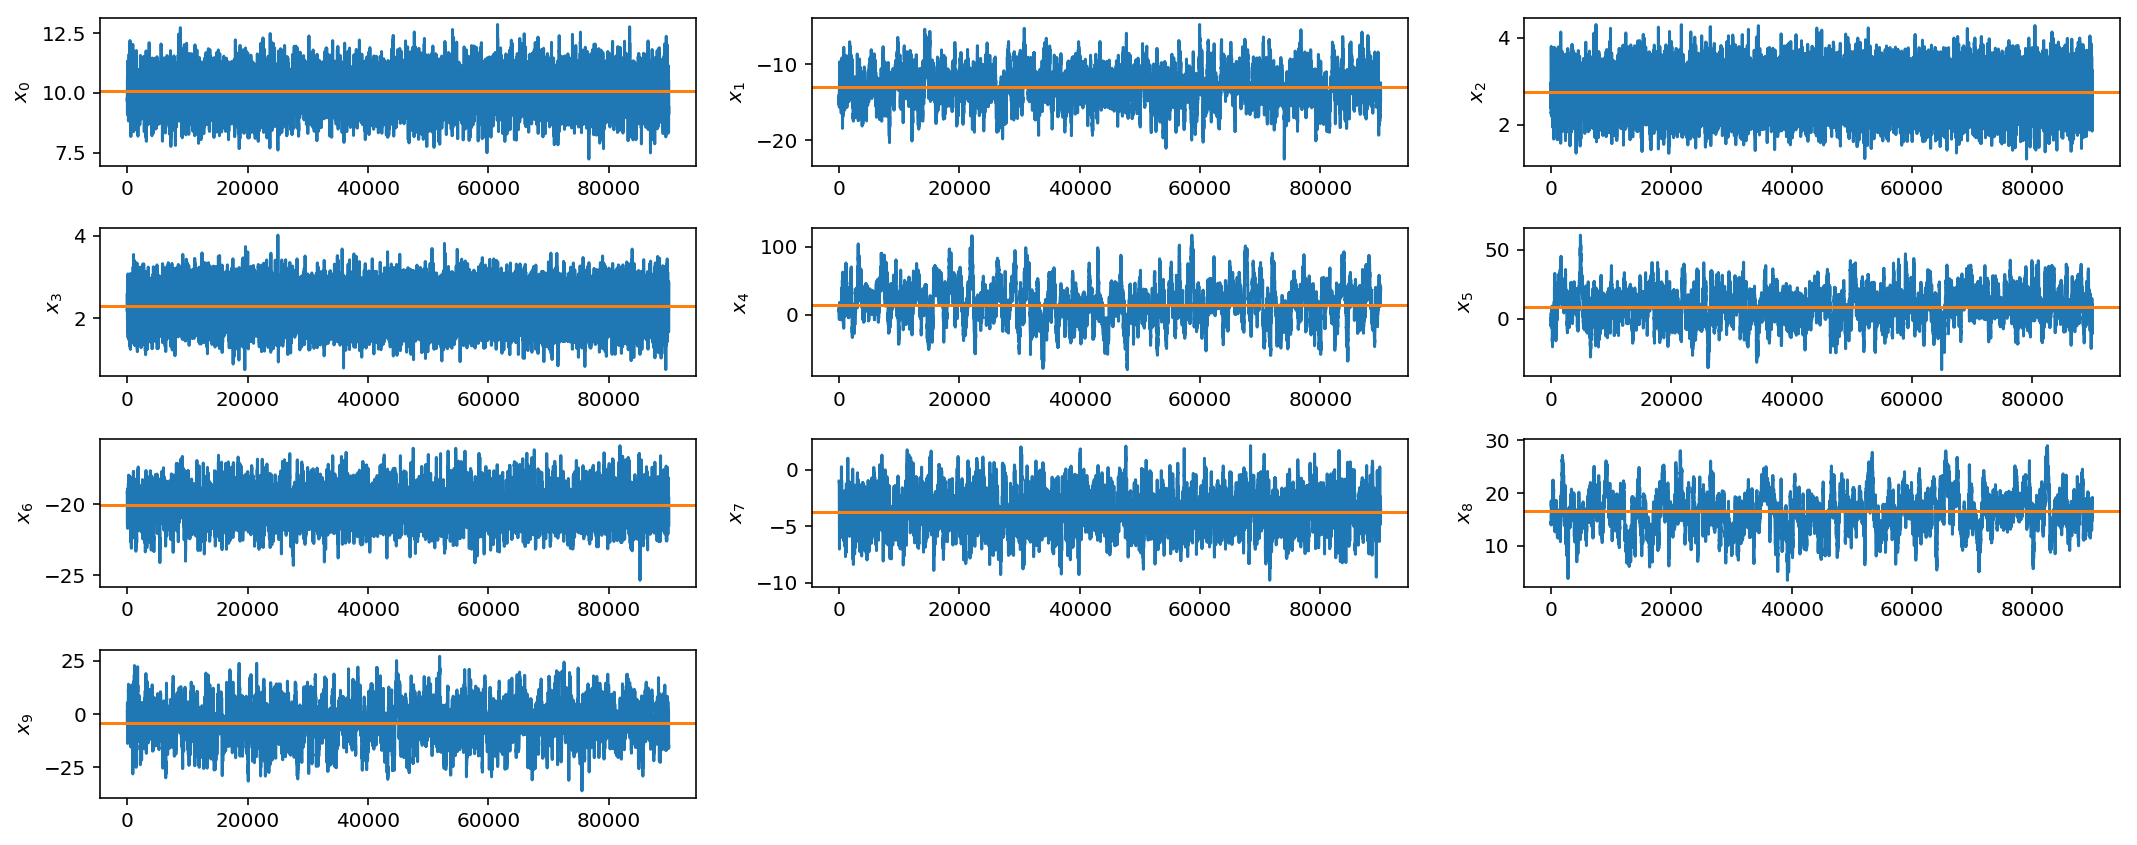

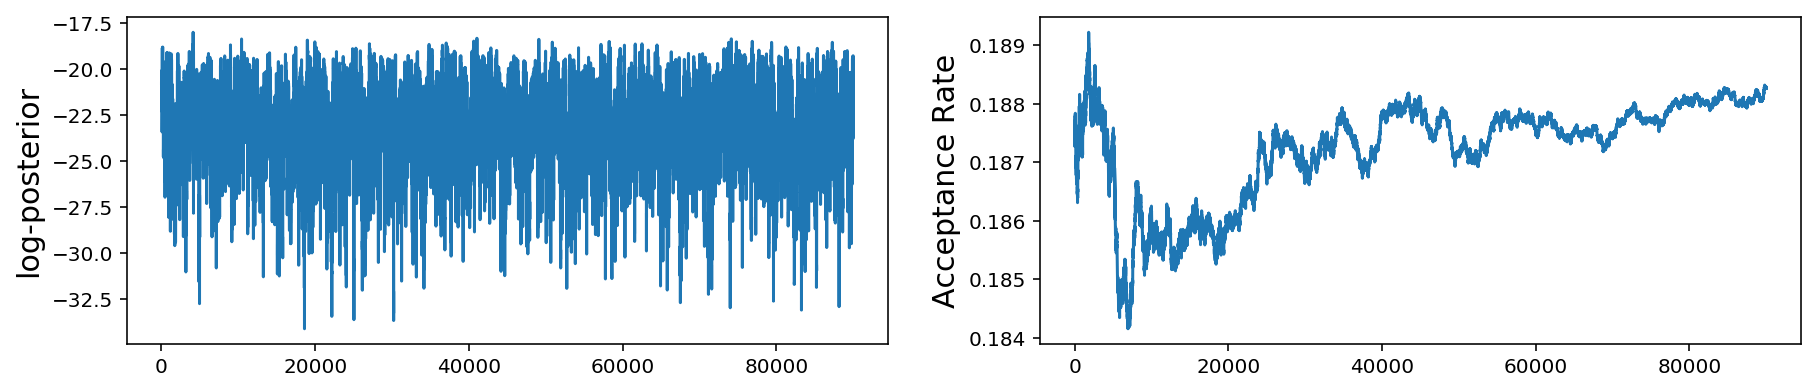

In [18]:
sigma = np.ones(10) * 0.8
sigma[4] = 6.0
sigma[5] = sigma[9] = 3.5
run_mcmc_plots_10d(sigma, iterations=100000)

OK, not perfect, but better. As you can imagine, this can get quite tedious when you have larger parameter spaces and more complicated posterior distributions. In later posts we will discuss how to automate this tuning process via adaptive jump proposals.

To wrap out this week though lets move to a slightly more realistic example: non-trivial covariance matrix and larger parameter space.

## Covariant parameters in high dimensions

This scenario is more realistic. In many cases, parameters have some covariance with one another and fancy techniques and tricks are really needed in high dimensions. 

Here we will sample from a 50-dimensional gaussian distribution with non-trivial covariance matrix.

In [19]:
class corr_gaussian_lnpost:
    """
    N-D Gaussian distribution with means drawn from
    
    mu ~ Normal(0, 1)
    
    and non-trivial dense covariance matrix.
    
    Prior on mean is U(-50, 50)

    :param ndim: Dimension of multivariate gaussian (default=10)
    :param seed: Random number seed for reproducible distribution
    
    """
    
    def __init__(self, ndim=50, seed=12343):
        
        np.random.seed(seed)
        self.mu = np.random.rand(ndim)
        
        M = np.random.randn(ndim, ndim)
        self.cov = np.dot(M, M.T)
        
    def __call__(self, x):
        """Return multivariate-normal log posterior
        
        :param x: Array of parameters
    
        :returns: log-posterior
        """
    
        if np.all(x < 50) and np.all(x > -50):
            return scipy.stats.multivariate_normal(mean=self.mu, cov=self.cov).logpdf(x)
        else:
            return -1e6

In [20]:
def run_mcmc_plots_corr(sigma, iterations=10000, ndim=50):
    x0 = np.random.randn(ndim)
    chain, ar, lnprob = mh_sampler(x0, corr_gaussian_lnpost(ndim=ndim), gaussian_proposal, 
                                   prop_fn_kwargs={'sigma':sigma}, iterations=iterations)

    burn = int(0.1 * chain.shape[0])
    
    lp = corr_gaussian_lnpost()
    mu, cov = lp.mu, lp.cov
    std = 1.5 * np.sqrt(np.diag(cov))
    
    corner(chain[burn:,:10]);

    plt.figure(figsize=(15, 6))
    for ii in range(10):
        plt.subplot(4,3,ii+1)
        plt.hist(chain[burn:, ii], 50, normed=True);
        plt.xlabel(r'$x_{}$'.format(ii))

    plt.tight_layout()
 
    plt.figure(figsize=(15, 6))
    for ii in range(10):
        plt.subplot(4,3,ii+1)
        plt.plot(chain[burn:, ii]);
        plt.ylabel(r'$x_{}$'.format(ii))
        plt.axhline(mu[ii], color='C1')
    plt.tight_layout()

    plt.figure(figsize=(15, 3))
    
    plt.subplot(121)
    plt.plot(lnprob[burn:])
    plt.ylabel('log-posterior', fontsize=15)

    plt.subplot(122)
    plt.plot(ar[burn:])
    plt.ylabel('Acceptance Rate', fontsize=15)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


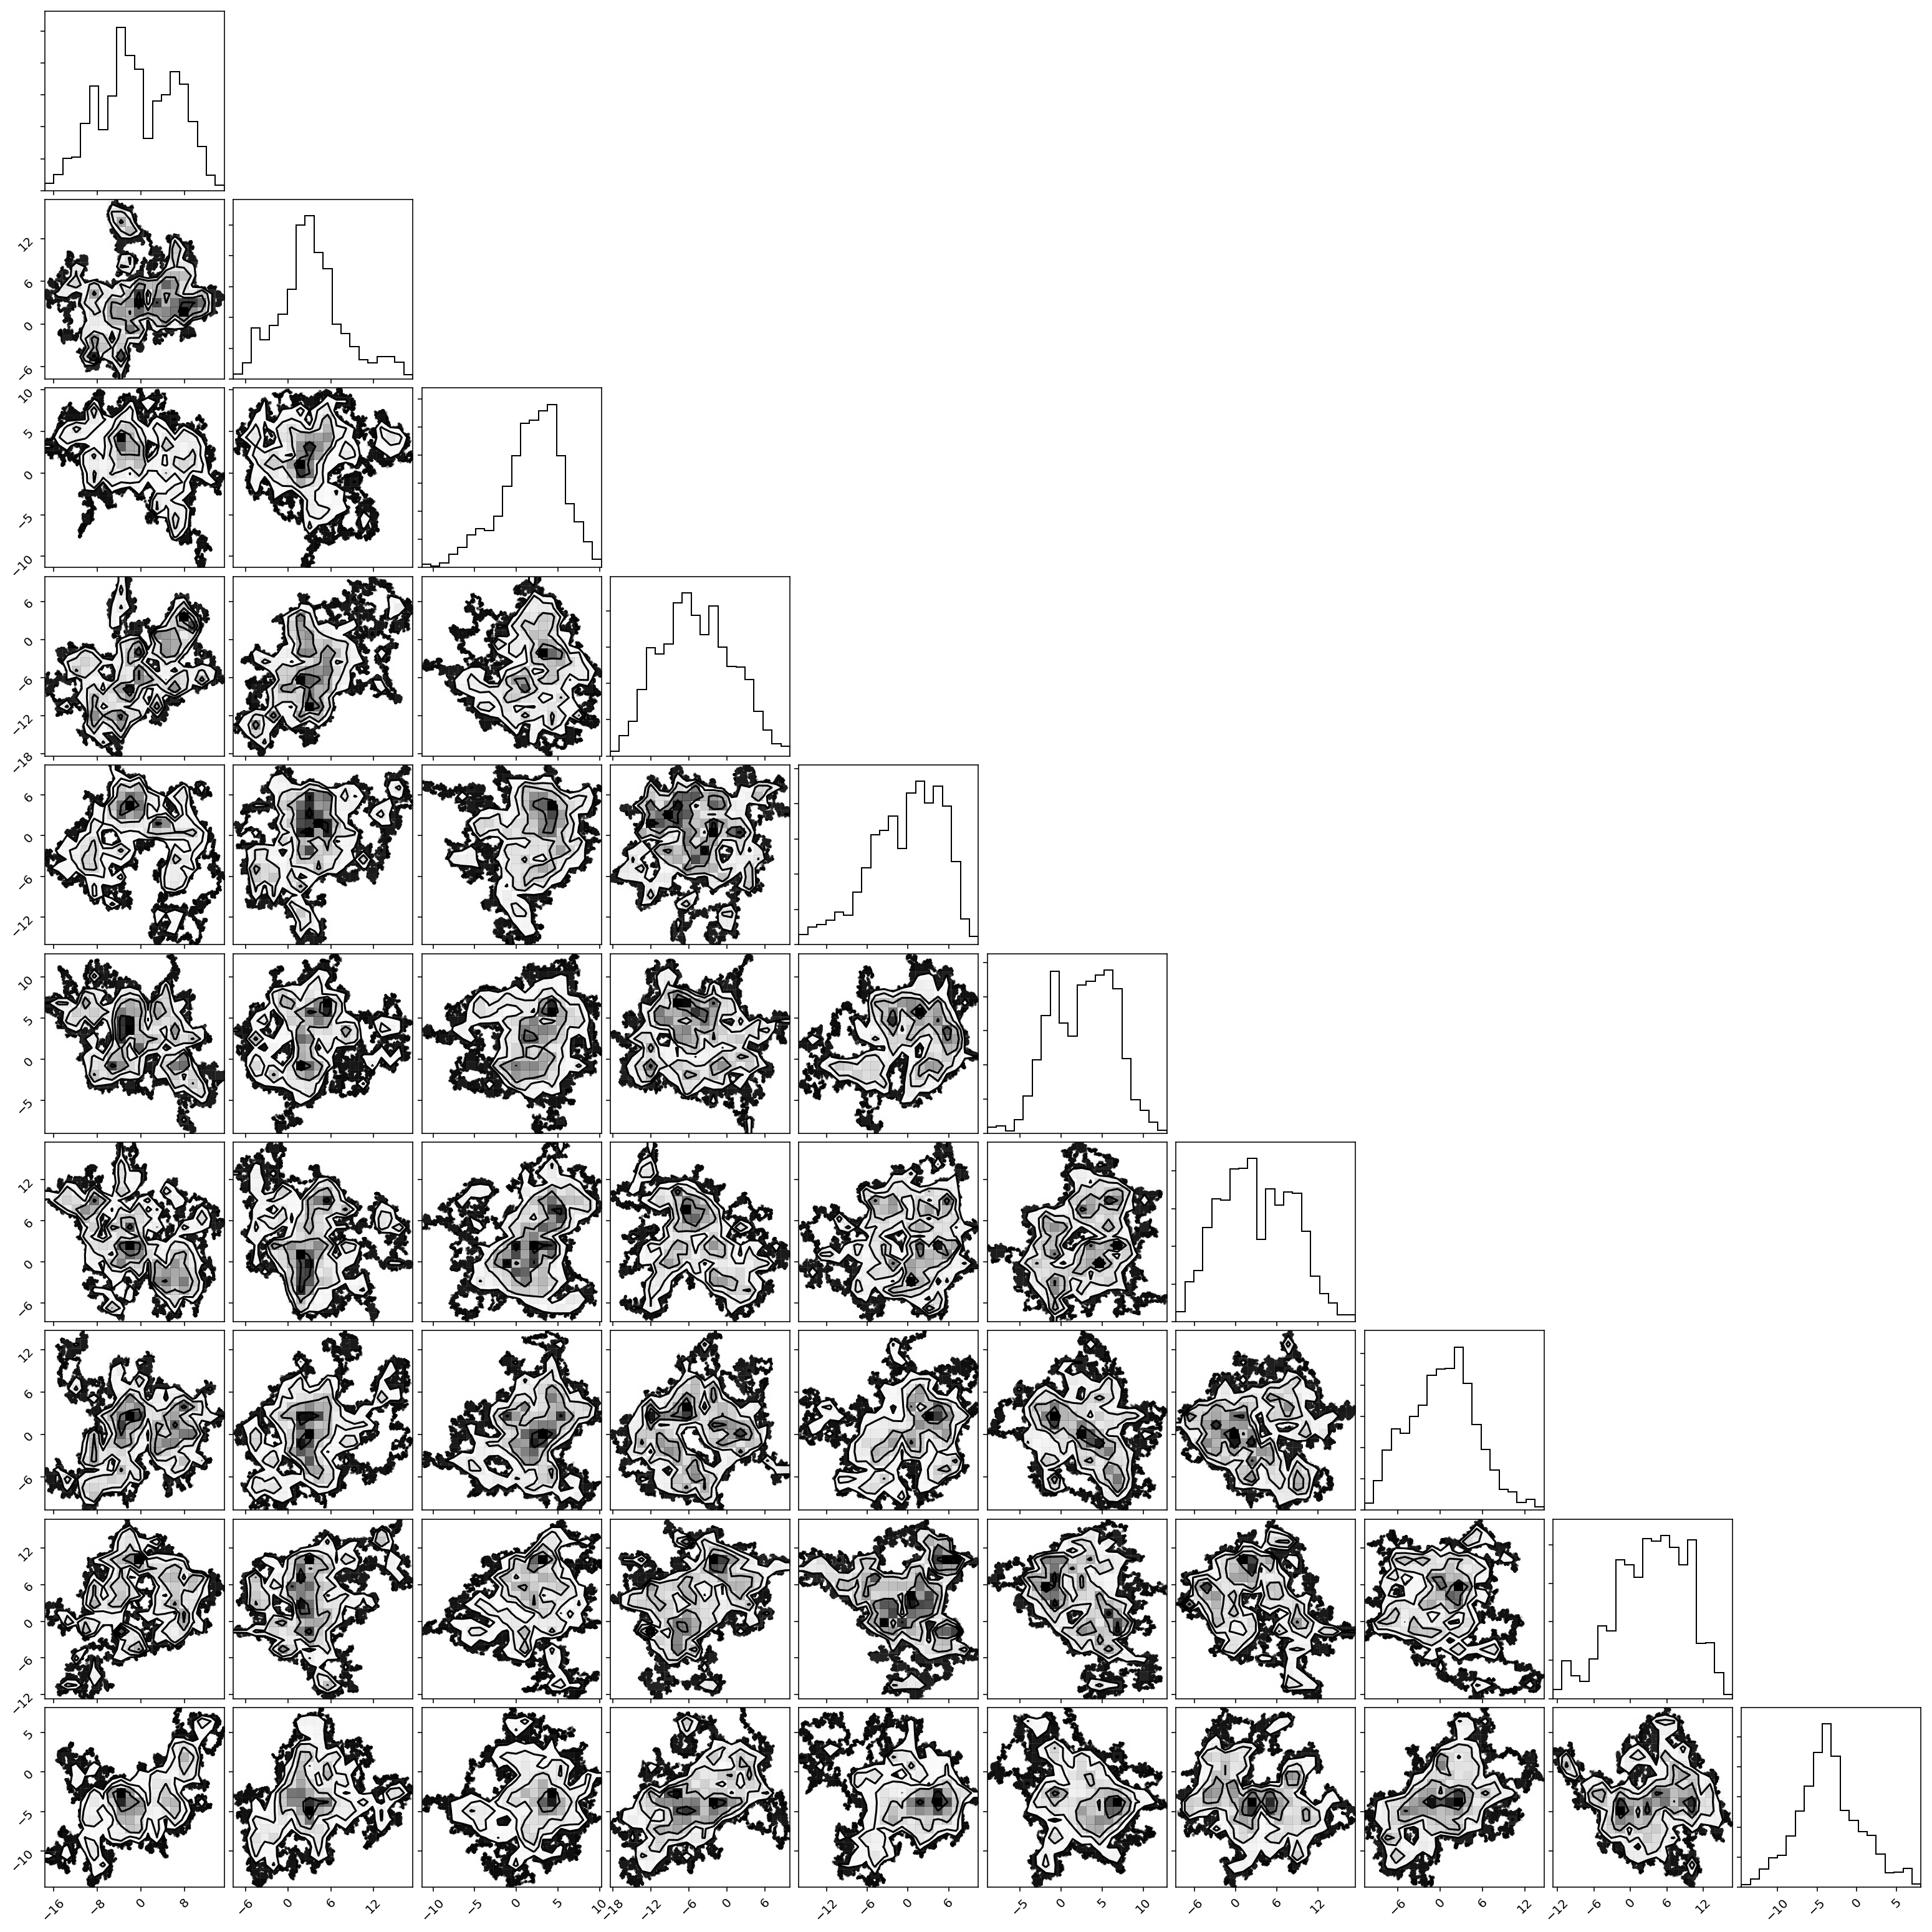

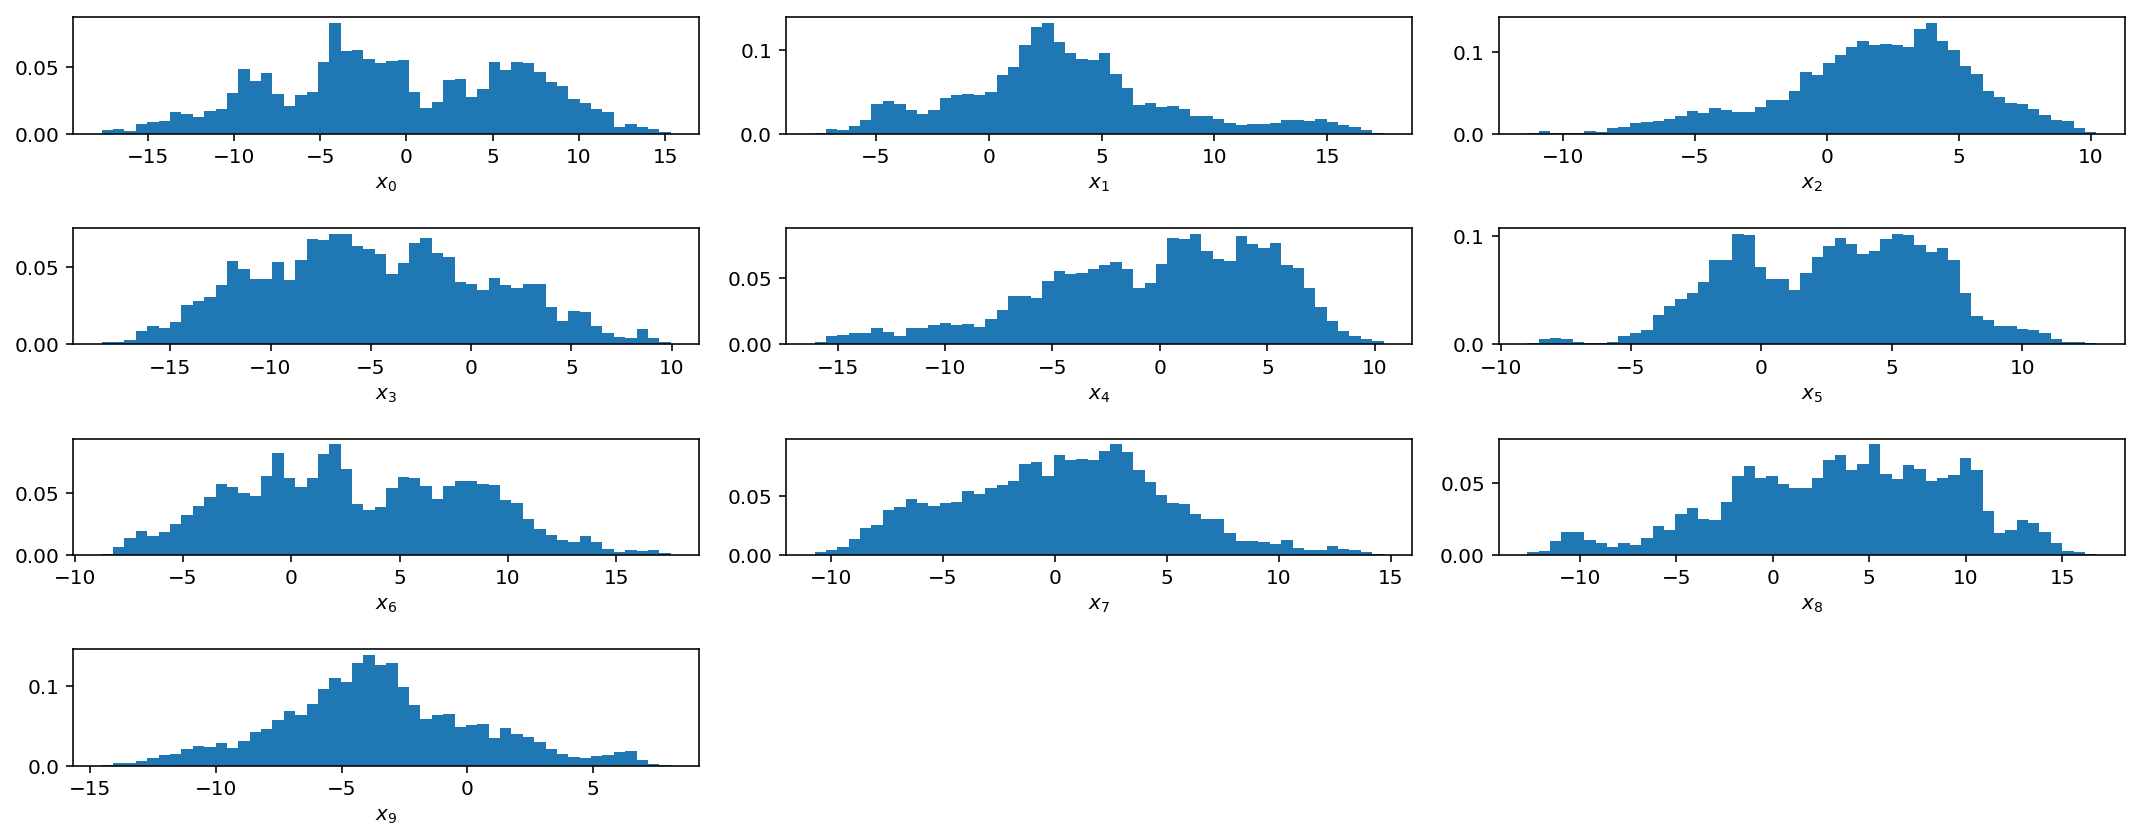

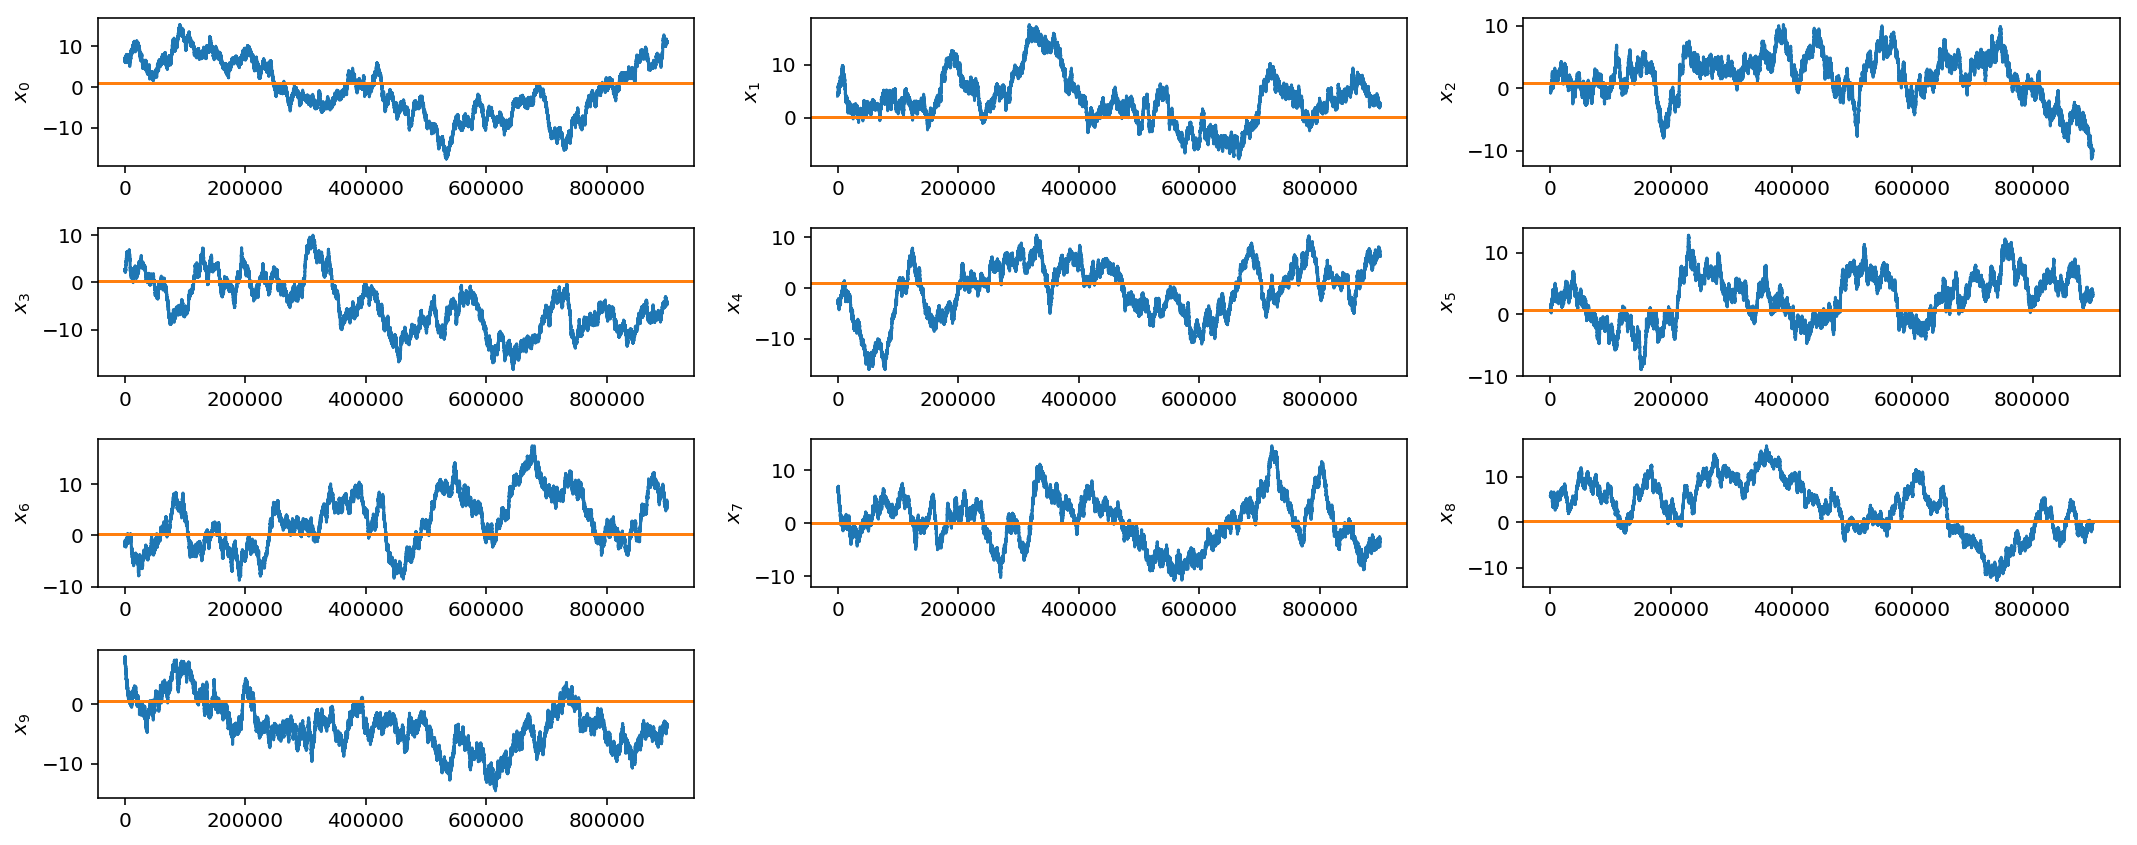

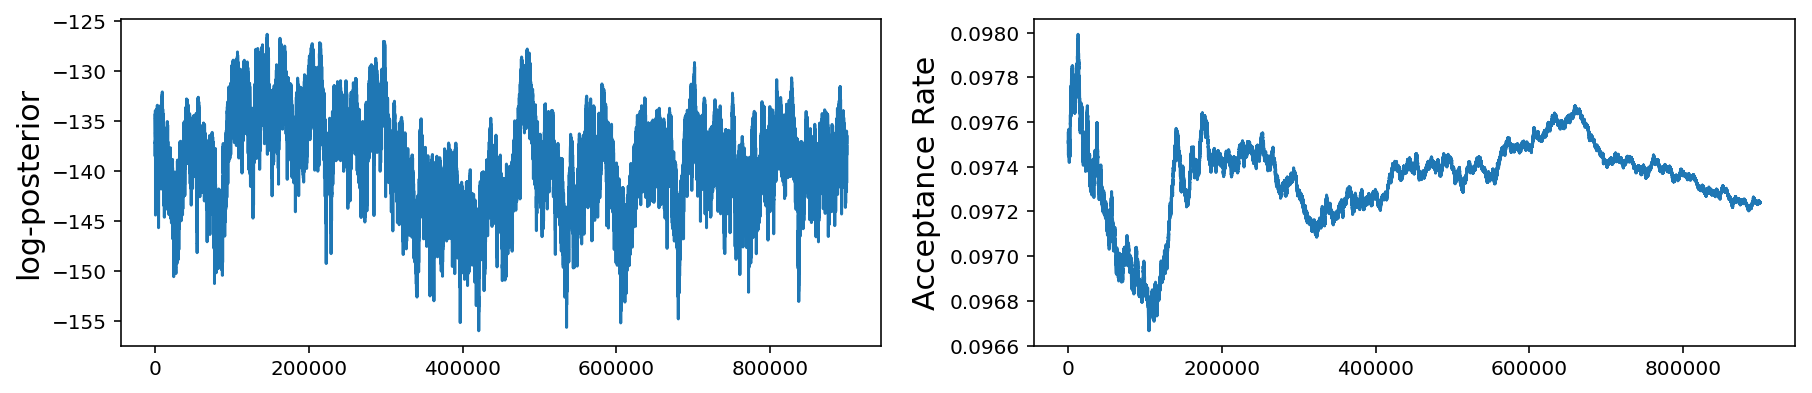

In [21]:
run_mcmc_plots_corr(0.1, iterations=1000000)

Above, we only plot the first 10 parameters but it is obvious that, even after 1 million samples, our gaussian jump proposal is not working very well at all as the chains have not converged. 

We will pick up with this problem next week when we introduce adaptive jump proposals and jump schedules.